## <font color='darkblue'>前言</font>
([Article source](https://medium.com/@cyeninesky3/oneclass-svm-%E7%95%B0%E5%B8%B8%E6%AA%A2%E6%B8%AC%E4%BB%BB%E5%8B%99-anomaly-detection-%E7%9A%84%E7%AE%97%E6%B3%95%E7%90%86%E8%A7%A3%E8%88%87%E5%AF%A6%E8%B8%90-cf5f0bbb01c0)) 因緣際會看了一篇 2016 KDD ( <font color='brown'>Knowledge Discovery and Data Mining Conference</font> ) 的 [Paper — Catch Me If You Can: Detecting Pickpocket Suspects from Large-scale Transit Records](https://www.kdd.org/kdd2016/papers/files/adf0629-duA.pdf)，其要解決的問題為在交通系統上能辨識出潛在小偷。

在數據方面，他們主要使用了北京公交一卡通數據進行探勘，並花了相當大的工作在特徵構建以及有趣的分析（<font color='brown'>例如小偷會在特定區域滯留、定義何為詭異行為、地圖劃分區域功能等</font>）；在算法方面，其最大的難點在於，行為複雜的乘客與小偷的 pattern 都屬於異常檢測算法當中在決策邊界以外的稀疏點，因此本篇使用了兩階段模型，<b>第一階段是異常檢測，即為本篇要介紹的 OneClass SVM，過濾出正常與異常行為的乘客，第二階段是 SVM 的分類模型，去改善異常當中被誤判為小偷的正常乘客分不好的情況</b>。

然而，<b>這類的問題存在重視高 Recall，忍受低 Precision 的情形</b>，這篇論文的 Recall = 0.927, Precision = 0.071，也就是說寧可錯抓，也不要漏放任何一位可疑的小偷。若對此篇論文有興趣，可以參考文末的 Sharing Slides。

## <font color='darkblue'>一、算法介紹</font>


### <font color='darkgreen'>Anomaly Detection 是什麼?</font>
又稱為異常偵測，要從茫茫數據中找到那些「長的不一樣」的數據，如下圖，理想中我們可以找到一個框住大部分正常樣本的 decision boarder，而在邊界外的數據點（<font color='blue'>藍點</font>）即視為異常。
![anomaly detection](images/1.PNG)
<br/>
但實際情況下數據都沒有標籤( <font color='brown'>label</font> )，因此很難定義「具有代表性的正常」區域。<b>異常偵測主要的挑戰如下：正常與異常行為之間的界限往往並不明確、不同的應用領域對異常的確切定義不同、數據可能含有噪聲、異常行為的數據較難以蒐集</b>（<font color='brown'>樣本量極少、在訓練時會有嚴重 imbalanced data 的問題</font>） 以及正常行為並不是一成不變，會有不斷發展變化的 pattern。

因此像是前言提到的的抓小偷、欺詐偵測、元件的損壞檢測等問題都能參考 Anomaly Detection 做為解法。異常偵測的算法非常多元，有興趣可以看這篇：[深入機器學習系列 — — 異常檢測 ( Anomaly Detection )](http://www.cainiaoxueyuan.com/suanfa/7017.html):
![anomaly detection](images/2.PNG)
<br/>
接下來，我們開始介紹本次的主角：[OneClass SVM 算法](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)（<font color='brown'>在 Catch Me If You Can 當中篩選行為異常的乘客</font>）。

### <font color='darkgreen'>OneClass SVM 簡介</font>
OneClass SVM 是一個 unsupervised 的算法，顧名思義訓練數據只有一個分類。<b>透過這些正常樣本的特徵去學習一個決策邊界，再透過這個邊界去判別新的資料點是否與訓練數據類似，超出邊界即視為異常。</b>

算法中使用到 [RBF](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) ( <font color='brown'>Gaussian Radial Basis Function</font> ) 的 Kernel 函數，是 SVM 分類算法中最為常用的 Kernel 函數，將特徵投影到高維空間（<font color='brown'>右下圖</font>）， maximize 高維空間與原點的距離，得到與原點距離最大的超平面。關於 RBF 如何經由泰勒級數推導得出 Kernel 函數，可以參考：[機器學習: Kernel 函數](https://medium.com/@chih.sheng.huang821/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-kernel-%E5%87%BD%E6%95%B8-47c94095171).
![anomaly detection](images/3.PNG)
<br/>
> Kernel函數：只要對所有的資料，有一個函數可以滿足 k(x,y)=⟨φ(x),φ(y)⟩ 這個 k(x,y) 就是一個 Kernel 函數，⟨a, b⟩ 表示向量 a 和 b 做內積。

## <font color='darkblue'>二、scikit — learn實踐</font>
透過 [sklearn.svm.OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) 我們可以簡單、方便的調用，以下使用 OneClass SVM 範例程式碼 體會一下OneClass SVM 針對偵測異常的邊界到底是怎麼決定的。

### <font color='darkgreen'>第一步：數據生成</font>
1. **X_train:** 產生兩組大小為 ( 100, 2 ) 並且服從常態分佈 𝑁( 𝜇, 𝜎² ) 的隨機數：X ~ N( 2, 0.3² ) 與 X~ N( -2, 0.3² ) ；接著將兩組隨機數透過 np.r_ 左右拼接。
2. **X_test:** 產生兩組大小為 ( 20, 2 ) 且服從常態分佈的隨機數，常態分佈的𝜇 與 𝜎 以及拼接方法同上。
3. **X_outliers:** 產生大小為 ( 20, 2 ) 介於 [-4, 4) 的隨機數。

In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# 訓練數據(正常)
X = 0.3 * np.random.randn(100, 2) # size=(100,2)
X_train = np.r_[X + 2, X - 2]     # size=(200,2)

# 測試數據(正常)
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]

# 測試數據(異常)
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

X_train.shape

(200, 2)

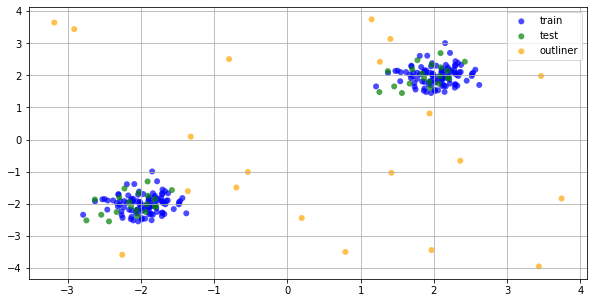

In [12]:
plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()
for color, title, datas in [
        ('blue', 'train', X_train),
        ('green', 'test', X_test), 
        ('orange', 'outliner', X_outliers)
    ]:    
    ax.scatter(datas[:, 0], datas[:, 1], c=color, label=title, alpha=0.7, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

### <font color='darkgreen'>第二步：模型訓練</font>
在 [scikit-learn 提供 OneClass SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) 的說明頁面有提到：<b>預測返回的 y 值為 1 代表正常 (<font color='brown'>inlier</font>)，返回值為 -1 代表異常 (<font color='brown'> outlier </font>)，與分類模型當中對應的 0 為正常、 1 為異常有所不同</b>。前面有提到我們是透過 unsupervised learning 的方式極小化正常樣本與邊界的距離，<font color='red'><b>因此邊界如何定義就是 `nu` 這個參數</b></font>（<font color='brown'>介於 0~1的比率</font>）<font color='red'><b>在控制的事情</b></font>。<b>舉例：<font color='violet'>nu =0.1</font>，代表了：正常樣本卻誤判為異常的最多不超過 10%</b> （<font color='brown'>以本範例來說，200 個樣本當中，被判為異常的要不超過 20 個</font>）；至少要有正常樣本的 10%（<font color='brown'>也就是 20 個</font>）作為衡量與邊界 margin 的 support vectors。
> nu: An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors. Should be in the interval (0, 1]. By default 0.5 will be taken.

而 <b>gamma 代表了 RBF Kernel 將樣本投影到高維空間的縮放比例，gamma 值設定的越小代表樣本在高維空間的越分散</b>，即 gamma 越大，在訓練時的作用可能會造成準確率較低，但預測未知樣本的泛化能力強；反之 gamma 值設定的越大，樣本在高維空間會擠在一起，所獲得的 support vectors 就會較少，訓練時準確率較高，但預測未知的泛化能力弱 ([RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)):
![anomaly detection](images/4.PNG)
<br/>

In [15]:
from sklearn import svm

# fit the model (nu=0.1)
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)

OneClassSVM(gamma=0.1, nu=0.1)

In [16]:
y_pred_train = clf.predict(X_train) 
y_pred_test = clf.predict(X_test)   
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size 

透過模型預測後，我們可以得到 `n_error_train` 、 `n_error_test` ，代表了實際正常誤判為異常的個數，在分類模型當中類似於 false positive 的概念 ( <font color='brown'>分類模型中實際為 0，誤判為 1</font> )； `n_error_outliers` 代表實際為異常誤判正常的個數，也就是其實是 outlier 但落在邊界內部裡，類似於 false negative (<font color='brown'>分類模型中實際為 1 ，誤判為 0 </font>)。

### <font color='darkgreen'>第三步：視覺化</font>
上面提到很多次的正常與異常樣本之間的決策邊界到底長什麼樣子呢？紅色邊界內為正常樣本（<font color='brown'>白色為正常的訓練數據、紫色為正常的測試數據</font>），而在紅色邊界以外的即判定為異常（<font color='brown'>黃色為異常的測試數據</font>）

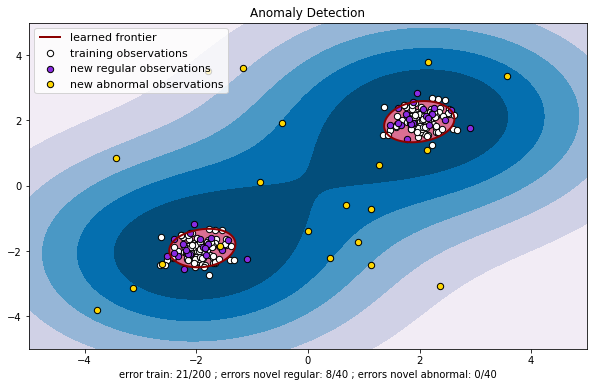

In [24]:
def draw_decision_boundary(nu=0.1, gamma=0.1):
    # Train the model
    clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
    clf.fit(X_train)
    
    xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

    # plot the line, the points, and the nearest vectors to the plane
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10,6))
    plt.title('Anomaly Detection')
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
    a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

    s = 40
    b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
    b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s, edgecolors='k')
    c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s, edgecolors='k')
    plt.axis('tight')
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([a.collections[0], b1, b2, c],
               ['learned frontier', 'training observations',
                'new regular observations', 'new abnormal observations'],
               loc='upper left',
               prop=matplotlib.font_manager.FontProperties(size=11))
    plt.xlabel('error train: %d/200 ; errors novel regular: %d/40 ; '
               'errors novel abnormal: %d/40' % (n_error_train, n_error_test, n_error_outliers))
    plt.show()
    
draw_decision_boundary()

上圖為 `nu=0.1, gamma=0.1` 的結果; 接著來看 `nu=0.5`（下圖）的差異:

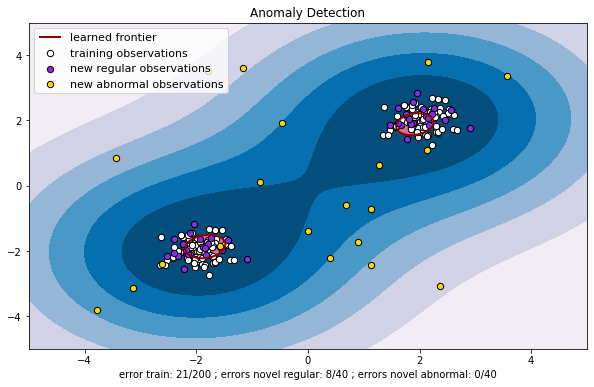

In [25]:
draw_decision_boundary(nu=0.5)

可以看到 OneClass SVM 學習到的決策邊界<b>在 `nu` 值越小的時候，紅色邊界所包含的範圍較大、也包含較多的正常樣本，但同時也有可能會發生誤把異常視為正常的缺點</b>。因此，如果不希望異常誤判為正常（<font color='brown'>意即想要擁有較小的 false negative</font>），則可以將紅色邊界內縮， `nu` 值設為大一些（<font color='brown'>default 值是設為 0.5</font>）。

## <font color='darkblue'>Supplement</font>
* [深入機器學習系列——異常檢測(Anomaly Detection)](http://www.cainiaoxueyuan.com/suanfa/7017.html)
> 異常檢測(Anomaly Detection),它是機器學習的一個重要分支，實際應用領域廣泛，更與我們的生活息息相關。那麼什麼是異常檢測？其主要方法和目前所面臨的技術難題有哪些？本文或許能提供一些參考
* [Day07 - Learning Numpy - 建立、合併、分割](https://ithelp.ithome.com.tw/articles/10203624)
* [Slideshare - Catch me if you can: detecting pickpocket suspects from large-scale transit records](https://www.slideshare.net/ClaireHuang26/catch-me-if-you-can-detecting-pickpocket-suspects-from-largescale-transit-records-136394818)